In [2]:
import os
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

datadir = "../data/"
data = pd.read_csv(datadir + "SubjectAge.csv")
bins = [7, 12, 17, 25]
ageBinrNr2Value = {0: 10, 1: 15, 2:21}
data['ageBin'] = pd.cut(data['FlooredAge'], bins)
data['ageBinNr'] = data['ageBin'].cat.codes
data['ageBinValue'] = data.apply(lambda row: ageBinrNr2Value.get(row['ageBinNr'], 0), axis = 1)

In [3]:
def read_subject_nlls(data_folder):
    subject_nlls = {}
    for subject_id in os.listdir(data_folder):
        subdir = os.path.join(data_folder, subject_id)
        if not os.path.isdir(subdir):
            # We're looking for directories only. Skip everything else
            continue
        fold_nlls = []
        # Get nlls for all the folds
        for filename in os.listdir(subdir):
            filepath = os.path.join(subdir, filename)
            match = re.match("lltest\\d+\\.csv", filename)
            if not os.path.isfile(filepath) or not match:
                # Skip any file that doesn't fit the pattern
                continue
            for line in open(filepath):
                fold_nlls.append(float(line))
        # Use the average nll over all moves
        if len(fold_nlls) > 0:
            subject_nlls[subject_id.split("-")[0]] = mean(fold_nlls)
    return subject_nlls

def get_diffs(model1, model2, label):
    diffs = []
    missing = max(0, len(model2) - len(model1))
    for key in model1:
        if not key in model2:
            missing += 1
        else:
            diffs.append(model1[key] - model2[key])
    if missing != 0:
        print(f"Could only find {len(diffs)} differences for {label}. Subjects: {len(model1)} vs {len(model2)}")
    return diffs

In [4]:
def add_model(data, names, folder, name):
    subject_data = read_subject_nlls(folder)
    data[name] = data["StudyID"].map(subject_data)
    names.append(name)
    print(f"Read {len(data)} nlls in {folder}")

model_names = []

add_model(data, model_names, "../data/fit_main", "Main")
#add_model(data, model_names, "../data/fit_no_noise", "No noise")
add_model(data, model_names, "../data/fit_no_feature_drop", "No feature drop")
add_model(data, model_names, "../data/fit_no_prune", "No pruning")
add_model(data, model_names, "../data/fit_no_tree", "No tree")
add_model(data, model_names, "../data/fit_no_scale", "No active scaling")
add_model(data, model_names, "../data/fit_no_3_row", "No 3-in-a-row")
add_model(data, model_names, "../data/fit_no_2_con", "No connected 2-in-a-row")
add_model(data, model_names, "../data/fit_no_center", "No center")
add_model(data, model_names, "../data/fit_no_4_row", "No 4-in-a-row")
add_model(data, model_names, "../data/fit_no_2_unc", "No unconnected 2-in-a-row")

Read 158 nlls in ../data/fit_main
Read 158 nlls in ../data/fit_no_feature_drop
Read 158 nlls in ../data/fit_no_prune
Read 158 nlls in ../data/fit_no_tree
Read 158 nlls in ../data/fit_no_scale
Read 158 nlls in ../data/fit_no_3_row
Read 158 nlls in ../data/fit_no_2_con
Read 158 nlls in ../data/fit_no_center
Read 158 nlls in ../data/fit_no_4_row
Read 158 nlls in ../data/fit_no_2_unc


In [7]:
#Exclude subjects
#drop the double subject
data = data[~data.StudyID.str.contains("866")]
# drop the subject with extremely low elo
data = data[~data.StudyID.str.contains("236")] 
data["StudyID"].nunique()


156

In [22]:
def make_plot(data, model_colors):
    fig, ax = plt.subplots()
    
    compareToModel = "Main"
    myFontSize = 12
    
    loglik_main = -data[compareToModel].mean()
    loglik_diff = []
    loglik_sem  = []
    for model_name in model_names:
        diffs = data[compareToModel] - data[model_name]
        loglik_diff.append(diffs.mean())
        loglik_sem.append(diffs.std() / math.sqrt(len(diffs)))

    domain = [-2.55,-2.0]

    def markSection(ax, label, x, y):
        ax.axhline(y = y-0.5, color='black', linestyle = 'dashed')
        ax.text(x, y, label, ha ='left', va='bottom', fontsize=myFontSize)

    ax.set_ylim([0.5,len(model_names)+0.5])
    ax.set_yticks(range(len(model_names),0,-1))
    ax.set_yticklabels(model_names, fontsize = myFontSize)
    ax.xaxis.set_tick_params(labelsize = myFontSize)
    ax.barh(range(len(model_names),0,-1), loglik_diff,
            xerr = loglik_sem,
            height = 0.5, align='center',
            color = model_colors, ecolor='black', left=loglik_main)
    ax.plot(loglik_main, len(model_names),'.k')
    ax.axvline(x=loglik_main, color='black')
    markSection(ax, 'Lesions: components', domain[0], 11)
    markSection(ax, 'Lesions: features', domain[0], 6)
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(domain)

    # fig.tight_layout()
    # fig.savefig(direc + 'loglik_rep_A.pdf')
    #plt.show()
    ax.figure.savefig("../data/Final_lesion_adul.pdf", dpi=300, bbox_inches='tight')

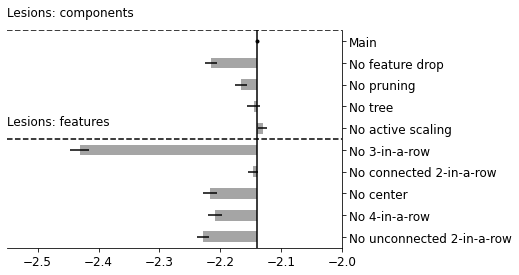

In [16]:
make_plot(data,['black'] + ['#a5a5a5'] * 10)


In [18]:
data = data.dropna() 
datachild = data[data["ageBinNr"] == 0]
dataadoles = data[data["ageBinNr"] == 1]
dataadult = data[data["ageBinNr"] == 2]

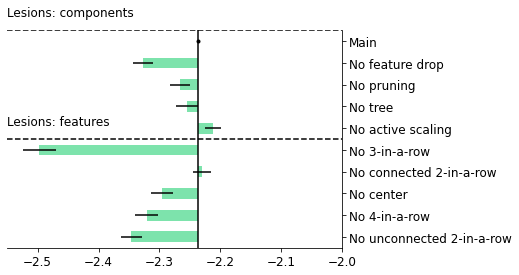

In [19]:
make_plot(datachild, ['black'] + ['#7DE3AC'] * 10)


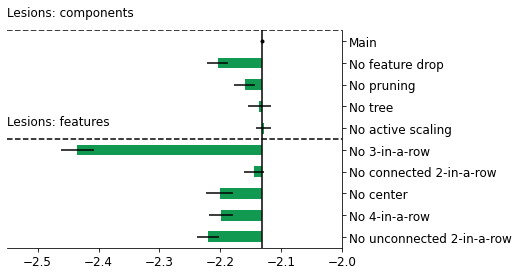

In [21]:
make_plot(dataadoles, ['black'] + ['#129951'] * 10)

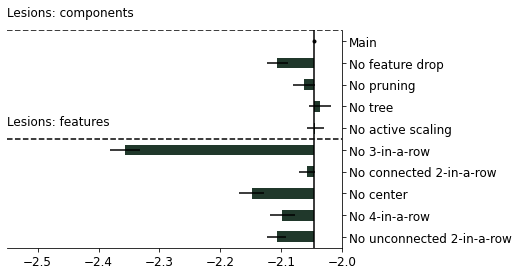

In [23]:
make_plot(dataadult, ['black'] + ['#20382B'] * 10)

In [78]:
import scipy.stats as sts
sts.spearmanr(data["ExactAge"], data["No tree"])

SpearmanrResult(correlation=-0.2358061276999217, pvalue=0.01447985156774727)

In [79]:
0.05/11

0.004545454545454546